In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os
from typing import Literal   

from statsmodels.tsa.api import VAR
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from Forcasting_lib import load_fred_data, load_fred_MD_data,  make_stationary, standardize_data


In [2]:
import tf_keras as keras  
from keras.utils import plot_model
from tf_keras import layers
from tf_keras import Sequential
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tf_keras import Model
from tf_keras.losses import MeanSquaredError
from tf_keras.layers import LSTM, Dense, Input, Dropout
from tf_keras.optimizers import Adam
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
mse_loss = MeanSquaredError()

# TensorFlow Probability
tfd = tfp.distributions
tfpl = tfp.layers



In [3]:
from __future__ import annotations
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional


In [13]:
def load_mixed_data_m_q():
    """
    Lädt die gemischten Daten (monatlich und quartalsweise), 
    macht sie stationär und standartisiert sie. 
    Gibt sie als DataFrame zurück.
    """
    q, tfcode = load_fred_data()
    q = make_stationary(q, tfcode)

    m , tfcode= load_fred_MD_data()
    m = make_stationary(m, tfcode)

    ## Quartalsweise verügbar
    q_columns= [
        "GDPC1",  # Real GDP
        "FPIx",   # Producer Price Index
        "PCDGx",  # Real Personal Consumption Expenditures
        "PCECC96" # Real Personal Consumption Expenditures Chain-Type Price Index
    ]

    q, scaler = standardize_data(q, q_columns)
    q = q[q_columns]

    ## Monatlich verfügbar 
    m_columns = [
        "UNRATE",  # Arbeitslosenquote
        "PAYEMS",  # Beschäftigung
        "GS10",  # 10-jährige Staatsanleihenrendite
        "S&P 500",  # Aktienmarktindex
        "CE16OV",  # Konsumklimaindex
        "CPIAUCSL",  # Verbraucherpreisindex (VPI)
        "TB3MS"  # 3-monatige Treasury-Bills
    ]

    m , scaler= standardize_data(m, m_columns)
    m = m[m_columns]

    return m.dropna(), q.dropna()

In [ ]:
def build_sequences(
    monthly_df: pd.DataFrame,
    quarterly_df: pd.DataFrame,
    target_col: str,
    win_m: int = 12,
    win_q: int = 4,
    align_to: str = "quarter_end",
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Erzeuge getrennte Sequenzen für Monats- und Quartalsdaten.
    - wählt nur Quartale, für die beide Fenster (win_m, win_q) voll sind
    Gibt zurück:
    - X_m: Array der monatlichen Sequenzen
    - X_q: Array der quartalsweisen Sequenzen
    - y: Array der Zielwerte (Quartalsdaten)
    - idx: Array der Indizes der Quartalsdaten
    """
    if align_to not in {"quarter_end", "quarter_start"}:
        raise ValueError("align_to must be 'quarter_end' or 'quarter_start'")

    monthly_df = monthly_df.sort_index()
    quarterly_df = quarterly_df.sort_index()

    # PeriodIndex -> DatetimeIndex (start/end of quarter)
    q_periods = quarterly_df.index.to_period('Q')
    if align_to == "quarter_end":
        align_ts = q_periods.end_time  # DatetimeIndex
    else:
        align_ts = q_periods.start_time

    m_index = monthly_df.index.values  # numpy array of datetime64

    X_m_list, X_q_list, y_list, idx_list = [], [], [], []

    for q_idx, m_ts in zip(quarterly_df.index, align_ts):
        # Position des letzten Monats <= m_ts finden
        pos = np.searchsorted(m_index, np.datetime64(m_ts), side="right") - 1
        if pos < 0:
            continue
        if pos - win_m < 0:
            continue
        q_end_loc = quarterly_df.index.get_loc(q_idx)
        if q_end_loc - win_q < 0:
            continue

        X_m_seq = monthly_df.iloc[pos - win_m: pos].values
        X_q_seq = quarterly_df.iloc[q_end_loc - win_q: q_end_loc].values
        y_val = quarterly_df.loc[q_idx, target_col]

        X_m_list.append(X_m_seq)
        X_q_list.append(X_q_seq)
        y_list.append(y_val)
        idx_list.append(q_idx)

    X_m = np.array(X_m_list)
    X_q = np.array(X_q_list)
    y = np.array(y_list)
    idx = np.array(idx_list)
    return X_m, X_q, y, idx


In [ ]:
def build_lstm_dual_input(
    win_m: int,
    n_m_features: int,
    win_q: int,
    n_q_features: int,
    hidden_m: int = 64,
    hidden_q: int = 32,
    dropout: float = 0.2,
    lr: float = 1e-3,
) -> keras.Model:
    """
    LSTM-Subnetz für Monatsdaten + Dense/LSTM für Quartalsdaten.
    """

    # Monats-Subnetz
    inp_m = keras.Input(shape=(win_m, n_m_features), name="monthly_input")
    x_m = layers.LSTM(hidden_m, return_sequences=False, name="lstm_monthly")(inp_m)
    x_m = layers.Dropout(dropout, name="drop_monthly")(x_m)

    # Quartals-Subnetz
    inp_q = keras.Input(shape=(win_q, n_q_features), name="quarterly_input")
    x_q = layers.LSTM(hidden_q, return_sequences=False, name="lstm_quarterly")(inp_q)
    x_q = layers.Dropout(dropout, name="drop_quarterly")(x_q)

    # Merge
    x = layers.Concatenate(name="concat")([x_m, x_q])
    x = layers.Dense(32, activation="relu", name="dense_merge")(x)
    out = layers.Dense(1, name="output")(x)

    model = Model(inputs=[inp_m, inp_q], outputs=out, name="LSTM_DualInput")
    model.compile(optimizer=Adam(lr), loss="mse")
    return model

In [ ]:
def build_bnn_dual_input(
    win_m: int,
    n_m_features: int,
    win_q: int,
    n_q_features: int,
    hidden_m: int = 64,
    hidden_q: int = 32,
    hidden_merge: int = 32,
    lr: float = 1e-3,
    aleatoric: bool = False,
    epochs: int = 50,
    batch_size: int = 16,
):
    """
    Bayesian DenseFlipout-Layer für epistemische Unsicherheit.
    Wenn aleatoric=True, wird auch die Varianz mitgeschätzt (Normalverteilungsausgabe).
    """
    inp_m = keras.Input(shape=(win_m, n_m_features), name="monthly_input")
    x_m = layers.Flatten()(inp_m)
    x_m = tfpl.DenseFlipout(hidden_m, activation="relu", name="bnn_monthly")(x_m)

    inp_q = keras.Input(shape=(win_q, n_q_features), name="quarterly_input")
    x_q = layers.Flatten()(inp_q)
    x_q = tfpl.DenseFlipout(hidden_q, activation="relu", name="bnn_quarterly")(x_q)

    x = layers.Concatenate(name="concat")([x_m, x_q])
    x = tfpl.DenseFlipout(hidden_merge, activation="relu", name="bnn_merge")(x)

    if aleatoric:
        params = tfpl.IndependentNormal.params_size(1)
        x = tfpl.DenseFlipout(params, name="params")(x)
        out = tfpl.IndependentNormal(1, name="output")(x)
        def nll(y, rv_y):
            return -rv_y.log_prob(y)
        loss = nll
    else:
        out = tfpl.DenseFlipout(1, name="output")(x)
        loss = "mse"

    model = Model(inputs=[inp_m, inp_q], outputs=out, name="BNN_DualInput")
    model.compile(optimizer=Adam(lr), loss=loss)
    return model


In [ ]:
## Rückgabecontainer, für beide Modelle gleich 
@dataclass
class EvalResult:
    rmse: float
    y_true: List[float]
    y_pred_mean: List[float]
    y_pred_lower: List[float]
    y_pred_upper: List[float]
    index: List[pd.Timestamp]


def evaluate_bnn_epistemic_dual(
    Xm: np.ndarray,
    Xq: np.ndarray,
    y: np.ndarray,
    idx: np.ndarray,
    initial_window: int = 80,
    n_samples: int = 100,
    hidden_m: int = 64,
    hidden_q: int = 32,
    hidden_merge: int = 32,
    win_m: int = 12,
    win_q: int = 4,
    epochs: int = 50,
    lr: float = 1e-3,
    batch_size: int = 16,
) -> EvalResult:
    """
    Rolling Evaluation für epistemische Unsicherheit via MC-Sampling.
    Ist Expanding Window, d.h. Training wird bei jedem Schritt neu auf dem bis dahin verfügbaren Sample durchgeführt
    """
    n_total = len(y)
    y_preds_mean, y_preds_lower, y_preds_upper, y_trues, idx_list = [], [], [], [], []

    for i in range(initial_window, n_total):
        Xm_train, Xq_train, y_train = Xm[:i], Xq[:i], y[:i]

        model = build_bnn_dual_input(
            win_m, Xm.shape[2], win_q, Xq.shape[2],
            hidden_m=hidden_m, hidden_q=hidden_q, hidden_merge=hidden_merge,
            epochs=epochs,lr=lr, aleatoric=False
        )
        model.fit([Xm_train, Xq_train], y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

        Xm_cur = Xm[i:i+1]
        Xq_cur = Xq[i:i+1]

        # MC-Sampling (epistemische Unsicherheit)
        preds = np.array([model([Xm_cur, Xq_cur], training=True).numpy().flatten()[0] for _ in range(n_samples)])
        pred_mean = preds.mean()
        ci_lower = np.percentile(preds, 2.5)
        ci_upper = np.percentile(preds, 97.5)

        y_preds_mean.append(pred_mean)
        y_preds_lower.append(ci_lower)
        y_preds_upper.append(ci_upper)
        y_trues.append(y[i])
        idx_list.append(idx[i])

    rmse = float(np.sqrt(np.mean((np.array(y_trues) - np.array(y_preds_mean))**2)))
    return EvalResult(rmse, y_trues, y_preds_mean, y_preds_lower, y_preds_upper, idx_list)



In [ ]:
def evaluate_lstm_dual(
    Xm: np.ndarray,
    Xq: np.ndarray,
    y: np.ndarray,
    idx: np.ndarray,
    initial_window: int = 80,
    win_m: int = 12,
    win_q: int = 4,
    hidden_m: int = 64,
    hidden_q: int = 32,
    dropout: float = 0.2,
    lr: float = 1e-3,
    epochs: int = 100,
    batch_size: int = 16,
) -> EvalResult:
    """
    LSTM 
    Nutzt ein expanding window für die Evaluation.
    """
    n_total = len(y)
    y_pred, y_trues, idx_list = [], [], []
    ci_lower, ci_upper = [], []

    for i in range(initial_window, n_total):
        Xm_train, Xq_train, y_train = Xm[:i], Xq[:i], y[:i]

        model = build_lstm_dual_input(
            win_m, Xm.shape[2], win_q, Xq.shape[2],
            hidden_m, hidden_q, dropout, lr
        )
        model.fit([Xm_train, Xq_train], y_train,
                  epochs=epochs, batch_size=batch_size,
                  validation_split=0.1, verbose=0)

        Xm_cur = Xm[i:i+1]
        Xq_cur = Xq[i:i+1]
        pred = model.predict([Xm_cur, Xq_cur], verbose=0).flatten()[0]

        y_pred.append(pred)
        y_trues.append(y[i])
        ci_lower.append(np.nan)
        ci_upper.append(np.nan)
        idx_list.append(idx[i])
    

    rmse = float(np.sqrt(np.mean((np.array(y_trues) - np.array(y_pred))**2)))
    return EvalResult(rmse, y_trues, y_pred, ci_lower, ci_upper, idx_list)


In [ ]:
## Verwandelt den Containter in ein DataFrame
def eval_to_df(res: EvalResult) -> pd.DataFrame:
    return pd.DataFrame({
        "y_true": res.y_true,
        "y_pred": res.y_pred_mean,
        "ci_lower": res.y_pred_lower,
        "ci_upper": res.y_pred_upper,
    }, index=pd.DatetimeIndex(res.index))

In [11]:
def run_pipeline(
    win_m: int = 12,
    win_q: int = 4,
    initial_window: int = 150,
    target_col: str = "GDPC1",
    model_type: str = "lstm",  # 'lstm' oder 'bnn'
    **model_kwargs,
) -> EvalResult:
    """Kompletter Ablauf: Daten laden, skalieren, Sequenzen bauen, evaluieren."""
    monthly_df, quarterly_df = load_mixed_data_m_q()
    Xm, Xq, y, idx = build_sequences(monthly_df, quarterly_df, target_col, win_m, win_q)

    if model_type == "lstm":
        res = evaluate_lstm_dual(Xm, Xq, y, idx, initial_window=initial_window, win_m=win_m, win_q=win_q, **model_kwargs)
    elif model_type == "bnn":
        res = evaluate_bnn_epistemic_dual(Xm, Xq, y, idx, initial_window=initial_window, win_m=win_m, win_q=win_q, **model_kwargs)
    else:
        raise ValueError("model_type muss 'lstm' oder 'bnn' sein")

    return res





In [26]:
RESULT = run_pipeline(
        win_m=12,
        win_q=4,
        initial_window=150,
        target_col="GDPC1",
        model_type="lstm",  # oder 'bnn'
        epochs=50,
        batch_size=16,
    )


df_result = eval_to_df(RESULT)
print("RMSE:", RESULT.rmse)
print(df_result.tail())

Datei './Data/FRED_QD_Data.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Datei './Data/FRED_MD_Data.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.
Standardisierung abgeschlossen.


RMSE: 1.2411948617200672
              y_true    y_pred  ci_lower  ci_upper
2023-12-01  0.041870 -0.541857       NaN       NaN
2024-03-01 -0.317684 -0.378239       NaN       NaN
2024-06-01 -0.004598  0.081995       NaN       NaN
2024-09-01  0.014603 -0.630759       NaN       NaN
2024-12-01 -0.128063  0.148982       NaN       NaN


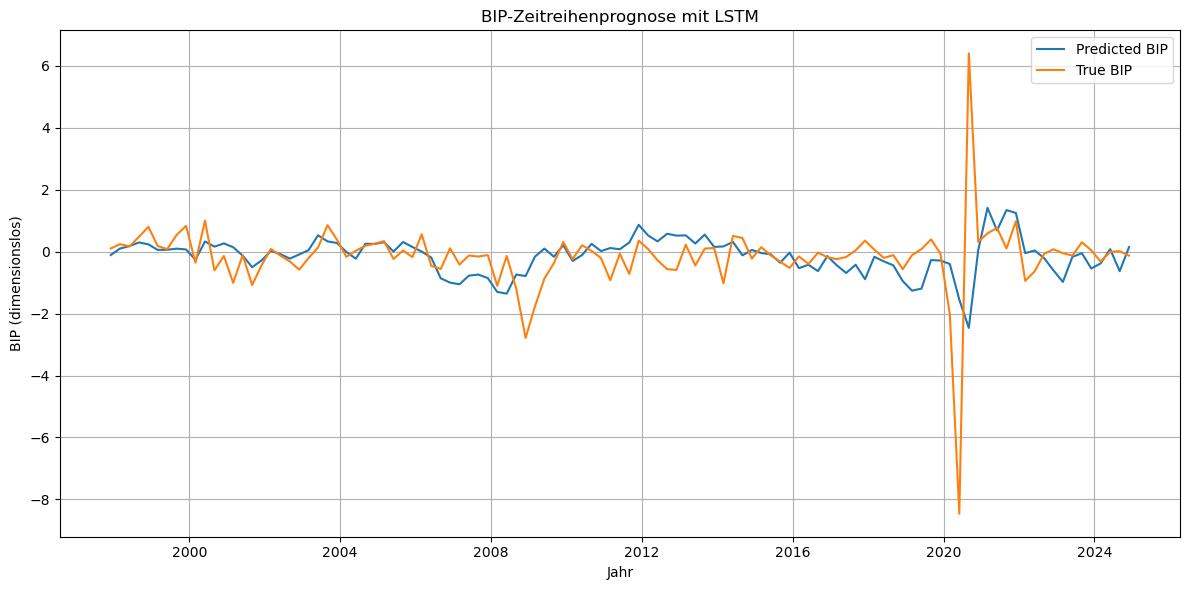

Calculated RMSE: 1.540564684760297


In [28]:
# Ergebnis-Plot
plt.figure(figsize=(12, 6))
plt.plot(df_result.index, df_result.y_pred, label="Predicted BIP")
plt.plot(df_result.index, df_result.y_true, label="True BIP")
plt.legend()
plt.title("BIP-Zeitreihenprognose mit LSTM")
plt.xlabel("Jahr")
plt.ylabel("BIP (dimensionslos)")
plt.grid(True)
plt.tight_layout()
plt.show()

rmse = mean_squared_error(df_result.y_true, df_result.y_pred)
print("Calculated RMSE:", rmse)

In [24]:
RESULT = run_pipeline(
        win_m=12,
        win_q=4,
        initial_window=150,
        target_col="GDPC1",
        model_type="bnn",  
        epochs=50,
        batch_size=16,
    )


df_result = eval_to_df(RESULT)
print("RMSE:", RESULT.rmse)
print(df_result.tail())

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.

Datei './Data/FRED_QD_Data.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Datei './Data/FRED_MD_Data.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.
Standardisierung abgeschlossen.


RMSE: 1.181089666169233
              y_true    y_pred  ci_lower  ci_upper
2023-12-01  0.041870 -0.051586 -3.432742  3.856829
2024-03-01 -0.317684 -0.150738 -3.487072  3.375027
2024-06-01 -0.004598 -0.159514 -3.085516  3.372598
2024-09-01  0.014603 -0.248086 -3.583241  3.246412
2024-12-01 -0.128063 -0.138728 -3.665968  3.346508


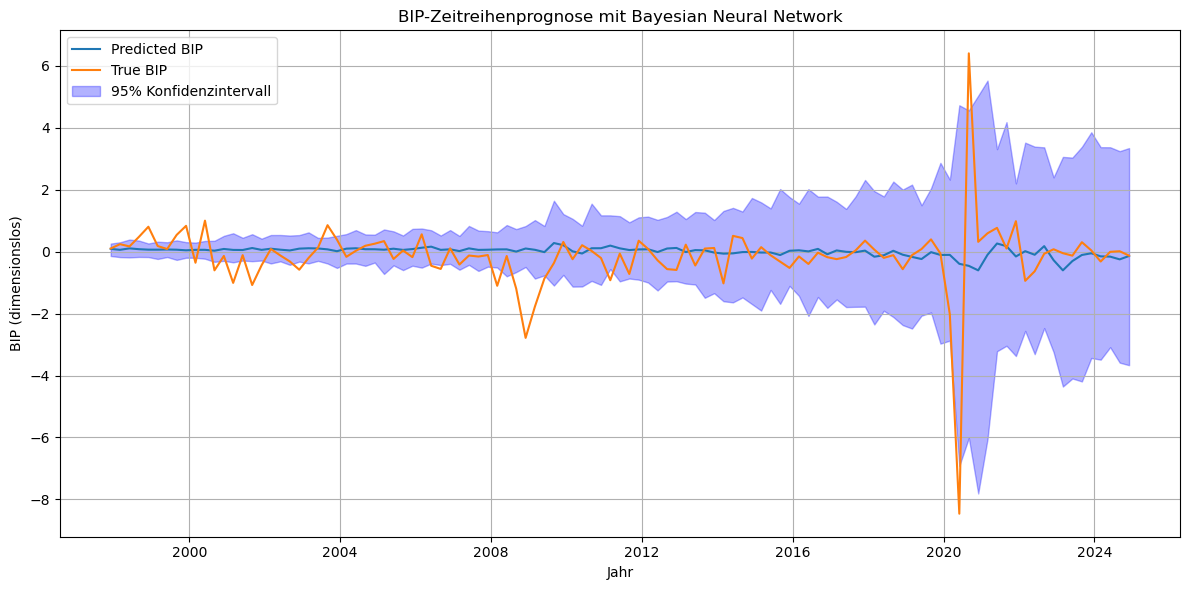

Calculated RMSE: 1.3949727995317502


In [25]:
# Ergebnis-Plot
plt.figure(figsize=(12, 6))
plt.plot(df_result.index, df_result.y_pred, label="Predicted BIP")
plt.plot(df_result.index, df_result.y_true, label="True BIP")
plt.fill_between(
    df_result.index,
    df_result.ci_lower,
    df_result.ci_upper,
    color="blue",
    alpha=0.3,
    label="95% Konfidenzintervall"
)
plt.legend()
plt.title("BIP-Zeitreihenprognose mit Bayesian Neural Network")
plt.xlabel("Jahr")
plt.ylabel("BIP (dimensionslos)")
plt.grid(True)
plt.tight_layout()
plt.show()

rmse = mean_squared_error(df_result.y_true, df_result.y_pred)
print("Calculated RMSE:", rmse)
